# COVID and Michigan's Economy
Goals: 
- Look at how COVID-19 pandemic has impacted Michigan's Economy
- Determine if economy has recovered. (compared to pre-COVID data)
- Breakdown the economy by class and two industries (Goods-producing and service-producing)

# Dependencies and Options##

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import datetime
import gmaps
from scipy import stats
from config import api_key, g_key
from pprint import pprint


#Displays Entire Dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Local Data
The local data is data downloaded from the Department of Labor and Opportunity Insights Economic Tracker. The Opportunity Insights Economic Tracker data is located at tracktherecovery.org and references paper at this link https://opportunityinsights.org/wp-content/uploads/2020/05/tracker_paper.pdf.

- Department of Labor
    - Provides total employment figures for the entire state of Michigan. 
    - Use this to find estimated daily employment count from Economic Tracker Data
- Economic Tracker
    - Large Dataset
    - Provides daily information

In [2]:
geo_path = 'Resources/data/GeoIDs - County.csv'
county_covid_path = 'Resources/data/COVID - County - Daily.csv'
emp_comb_path = 'Resources/data/Employment Combined - State - Daily.csv'
dol_path = 'Resources/MI_DOL_EMP_STATS.csv'

# API URLs
We are currently using 3 different API's in this project; Bureau of Labor Statistics' Public API, COVID Tracking's API, and Googles Geocoding API. 

- Bureau of Labor Statistics
    - Provides datasets broken down by Goods vs. Services industries
    - Reported Monthly
    - Data over 3 year period
- COVID Tracking API
    - Provides uptodate information regarding the COVID pandemic
    - Updated daily and consistently
    - Reports daily values.
- Geocoding API
    - Used to generate coordinates for a heatmap of MI counties


In [3]:
blsApi_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
covid_url = 'https://api.covidtracking.com/v1/states/mi/daily.json'
geocode_url = 'https://maps.googleapis.com/maps/api/geocode/json'

In [4]:
# Creating and cleaning DataFrame
response = (requests.get(covid_url).json())
covid_df = pd.DataFrame(response)
covid_df.dropna(axis=1, how='all', inplace = True)

#Deleting or Dropping irrelevant rows
del covid_df['hospitalizedIncrease'],covid_df['hash'],covid_df['commercialScore'],covid_df['negativeRegularScore'],covid_df['negativeScore'],covid_df['positiveScore'],covid_df['score'],covid_df['grade']
covid_df = covid_df.drop(columns = ['lastUpdateEt','dateModified','checkTimeEt','recovered','dataQualityGrade','totalTestResultsSource','dateChecked'])


In [5]:
# Trying to create consistent datetime column ot use with merge.
covid_dates = [datetime.date(int(str(x)[0:4]), int(str(x)[4:6]), int(str(x)[6:8])) for x in covid_df['date']]
covid_df['datetimes']=covid_dates


In [6]:
# MI Employment DF creation
emp_comb_df = pd.read_csv(emp_comb_path)
mi_emp_comb_df = emp_comb_df.loc[emp_comb_df['statefips']==26] #MI fips is 26
mi_emp_comb_df['number employed'] = (mi_emp_comb_df.iloc[:, 4] * 4774000)+4774000
mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']]= mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']].astype(float)*100
date = []
per_change = []
#Creating consistent datetime across dfs
for index in mi_emp_comb_df.index:
    date.append(datetime.date(mi_emp_comb_df.loc[index, 'year'],mi_emp_comb_df.loc[index, 'month'],mi_emp_comb_df.loc[index, 'day']))
    per_change.append(mi_emp_comb_df.loc[index, 'emp_combined'])
mi_emp_comb_df['datetimes'] = date
mi_emp_comb_df['emp_expected'] = mi_emp_comb_df['emp_combined'].mean()


C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\state\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [7]:
#Creating DF for county information
geo_id_df = pd.read_csv(geo_path)
county_covid_df = pd.read_csv(county_covid_path)
mi_county_id_df = geo_id_df.loc[geo_id_df['statename']=='Michigan']
mi_county_covid_df = pd.merge(county_covid_df, mi_county_id_df, on='countyfips', how='inner')
county_single_day = mi_county_covid_df.loc[(mi_county_covid_df['month']==9) & (mi_county_covid_df['day']==20)]

locations = []

for index, row in county_single_day.iterrows():
    county = row['countyname']
    state = row['stateabbrev']
    params = {'key': g_key,
             'address': f'{county} {state}'}
    county_json = requests.get(geocode_url, params = params).json()
    #was getting index errors when I had to recreate my API key for google. 
    try:
        lat = (county_json['results'][0]['geometry']['location']['lat'])
        lng = county_json['results'][0]['geometry']['location']['lng']
        locations.append((lat, lng))
    except IndexError:
        locations.append((0, 0))
county_single_day['location'] = locations



C:\Users\state\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Creating income classes for annova and respective columns for charting
low = mi_emp_comb_df['emp_combined_inclow']
middle = mi_emp_comb_df['emp_combined_incmiddle']
high = mi_emp_comb_df['emp_combined_inchigh']
mi_emp_comb_df[['lower', 'middle', 'upper']]=mi_emp_comb_df[['emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh']]

In [9]:
#Accessing API based on Documentation, must dig deep into website to find relevant information
# Series IDs for BLS datasets SMU26000000000000001 SMU26000000500000001 SMU26000000500000002 SMU26000000500000011 SMU26000000600000001 SMU26000000600000002 SMU26000000600000011 SMU26000000700000001 SMU26000000800000001 SMU26000000800000002 SMU26000000800000011

headers = {'Content-type': 'application/json'}
data =  json.dumps({"seriesid": ['SMU26000000000000001', 'SMU26000000500000001', 'SMU26000000500000002', 'SMU26000000500000011', 'SMU26000000600000001', 'SMU26000000600000002', 'SMU26000000600000011', 'SMU26000000700000001', 'SMU26000000800000001', 'SMU26000000800000002', 'SMU26000000800000011'],
                    'catalog':True,
                    "registrationkey" : f'{api_key}'})
bls_json = (requests.post(blsApi_url, data=data, headers = headers).json())


#Data Parsing
dframes = {}
# Loop creates dictionary dframes with keys being Commerce Industry + Measure Data Type from metadata and values are pandas dataframes
for series in bls_json['Results']['series']:
    dframes.update({series['catalog']['commerce_industry'] +' '+ series['catalog']['measure_data_type']:pd.DataFrame(series['data'])})
full_bls_df = dframes['Total Nonfarm All Employees, In Thousands']
for df_name, value_df in dframes.items():
    full_bls_df[df_name] = value_df['value']
full_bls_df = full_bls_df.drop(columns=['value', 'latest', 'footnotes'])
full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))]=full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))].astype(float)


full_bls_df = full_bls_df.iloc[::-1]  #Reverses dataframe order to set up charts correctly

## Plotting Positive Covid Tests
Almost to 140,000 positive cases in Michigan. 
- Notice that the curve levels off in May and June, but has increased steadily since then

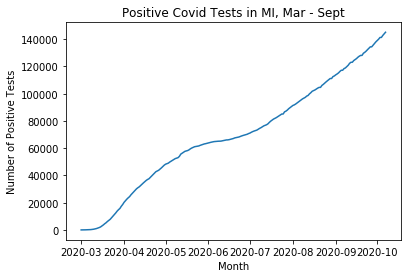

In [10]:
plt.plot(covid_df['datetimes'], covid_df['positive'])
plt.title('Positive Covid Tests in MI, Mar - Sept')
plt.ylabel('Number of Positive Tests')
plt.xlabel('Month')
plt.show()

## Heatmap by County
- Shows where COVID is located in the State
    - General Picture
    - County locations are based upon a text search of Google's Geocode API
    - Coordinates are for the center of the county so some dispersal may be off when zoomed in.
    - If API returns bad response, point is not charted.
    

In [11]:
gmaps.configure(api_key = g_key)
fig = gmaps.figure()
l = [x  for x in locations if x != (0,0)]  #Handling index errors
not_equat = county_single_day['case_count'].loc[county_single_day['location'] != (0,0)]  #Handling index errors
heatmap = gmaps.heatmap_layer(locations = l, weights = not_equat, max_intensity=5111, point_radius=20)
fig.add_layer(heatmap)
fig


Figure(layout=FigureLayout(height='420px'))

## Employment
To get a feel for a major trend in the data, this time series exhibits a large dip beginning in March and ending in the month of April. This dip coincides with the Governor's Mandate to stay at home, and a large influx of COVID cases. 

Data comes from the Economic Tracker

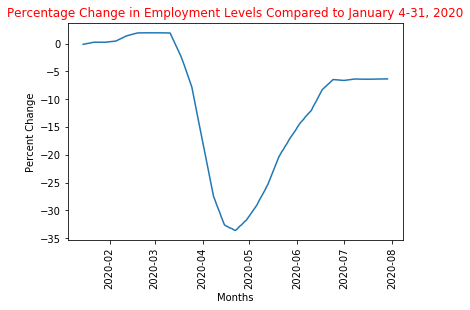

In [12]:
x_values = date
y_values = per_change
fig1  = plt.plot(x_values, y_values)
plt.title('Percentage Change in Employment Levels Compared to January 4-31, 2020', color = 'red')
plt.xticks(rotation = 90)
plt.xlabel('Months')
plt.ylabel('Percent Change')
plt.show()

## Employment by Industry
- Broke into 2 sections
    - Goods Producing, and Service Producing
    - Charting 3 elements of data;
        - Number of Employees
        - Average Hours Worked per week
        - Average Weekly Earnings
 - Trying to determine if the economy has recovered or not.
 
 ## Analysis
 - In some measures of the economy, we have reached pre-COVID levels, in others we have not.
 - Our total overall workforce is down almost 500,000 people from previous years
 - However, data shows that people who are still employed are working the same number of hours per week, and are making as much or more than they had in previous years.

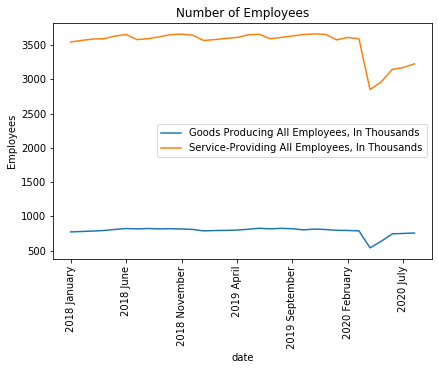

In [19]:
full_bls_df['date'] = full_bls_df['year']+' ' +full_bls_df['periodName']
full_bls_df.plot('date',['Goods Producing All Employees, In Thousands', 'Service-Providing All Employees, In Thousands' ],  kind = 'line')
plt.tight_layout()
plt.title('Number of Employees')
plt.xticks(rotation = 90)
plt.ylabel('Employees')
plt.show()

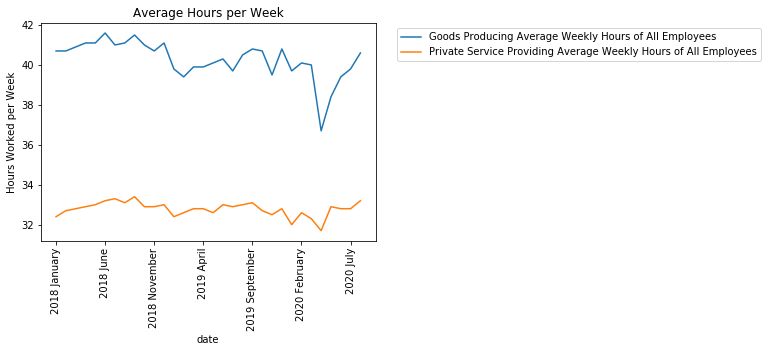

In [20]:
full_bls_df.plot('date', [ 'Goods Producing Average Weekly Hours of All Employees', 'Private Service Providing Average Weekly Hours of All Employees' ], kind = 'line')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 90)
plt.ylabel('Hours Worked per Week')
plt.title('Average Hours per Week')
plt.show()

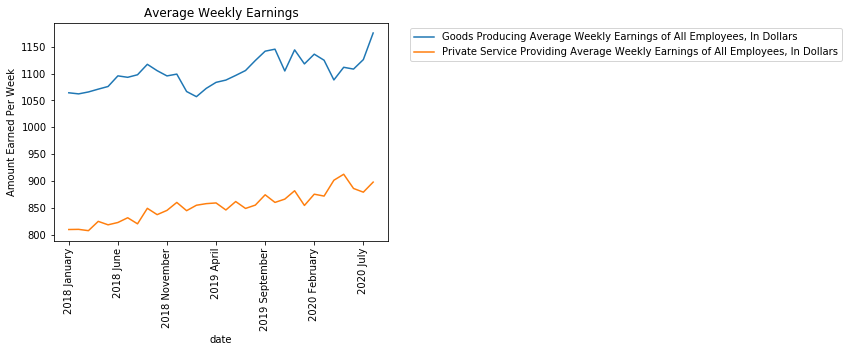

In [21]:
full_bls_df.plot('date', [ 'Goods Producing Average Weekly Earnings of All Employees, In Dollars', 'Private Service Providing Average Weekly Earnings of All Employees, In Dollars' ], kind = 'line')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 90)
plt.title('Average Weekly Earnings')
plt.ylabel('Amount Earned Per Week')
plt.show()

## Breakdown of Employment by Class
Using data provided by the Economic Tracker, we can determine whether class plays a role in employment during the pandemic.
***
Hypothesis: In the last six months,  the lower class was affected more by covid 19 than any other class.<br>
Null: In the last six months, employment is uncorrellated with income level throughout the pandemic. (pvalue must be less than .05 to reject)
***
Analysis:
 - First chart shows that there is a much steeper decline in employment for the lower 2 classes. 
 - Upper class employment numbers have returned to pre-COVID levels

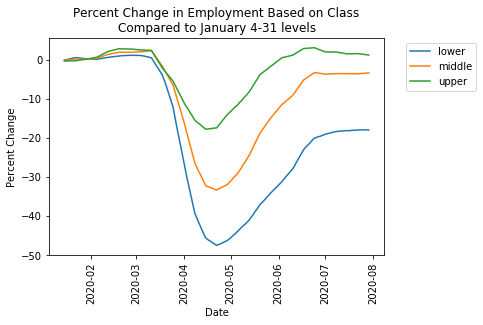

In [16]:
mi_emp_comb_df.plot('datetimes', ['emp_combined_inclow' , 'emp_combined_incmiddle', 'emp_combined_inchigh'], kind = 'line')
plt.title('Percent Change in Employment Based on Class\nCompared to January 4-31 levels')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels = ['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.show()

## Boxplot and Annova

We used an annova test to determine whether or not there was a statistically sigfinicant difference between the three classes. <br>
Similar to the line chart displayed, boxplot visually shows the difference between the three classes. 

 - When an Annova is performed on the data for the three classes, a pvalue of around 2e-35
 - Small enough to reject the null
     - When a t-test is performed on any two of the three classes, a low enough pvalue is returned to reject the null in that specific case. 

### Conclusion?
The difference in income class does have a significant impact on rate of employment change throughout the pandemic

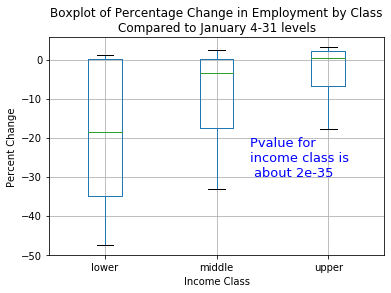

In [17]:
annova = (stats.f_oneway(low, middle, high))
mi_emp_comb_df.boxplot(['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.title('Boxplot of Percentage Change in Employment by Class\nCompared to January 4-31 levels')
plt.xlabel('Income Class')
plt.annotate(f'Pvalue for \nincome class is \n about {round(annova[1], 35)}', (2.3, -30), fontsize = 13, color = 'blue')
plt.show()

## Change in Employment vs. Increase in Positive COVID Tests

Comparing daily changes in employment to the daily changes in infection rate.
***
Hypothesis: As the amount of positive COVID tests increases, we expect the decrease in employment levels to increase. An r^2 value greater than .7 would be accepted.<br>
Null: The decrease in employment is not directly correlated with the number of COVID positive tests that day.
***
Analysis: 
At first glance, it is fairly clear that there is no clear correllation between these two data points. Government policies and mandates interfere with this comparison.

r^2 value: 0.15335440072049702


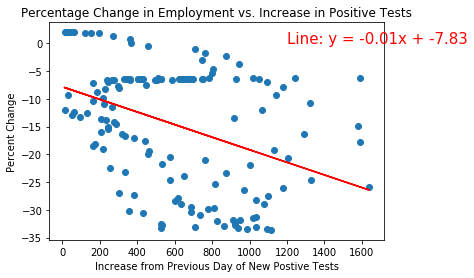

In [18]:
covid_emp_merge = pd.merge(covid_df, mi_emp_comb_df, on='datetimes', how = 'inner')
covid_emp_merge = covid_emp_merge.loc[covid_emp_merge['positiveIncrease']!=0] 
x_values = covid_emp_merge['positiveIncrease']
y_values = covid_emp_merge['emp_combined']
plt.scatter(x_values, y_values)
plt.title('Percentage Change in Employment vs. Increase in Positive Tests')
plt.ylabel('Percent Change')
plt.xlabel('Increase from Previous Day of New Postive Tests')
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "Line: y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1200,0),fontsize=15,color="red")
print(f'r^2 value: {rvalue*rvalue}')
plt.show()

### Conclusion?
With an r<sup>2</sup> value less than we can accept, we are accepting the null hypothesis; The decrease in employment is not directly correlated with the number of COVID positive tests that day.

# Overall
- Several parts of the economy were hurt by the COVID pandemic. Some more than others
- Determined that income class does have a significant impact on the rate of employment change through the pandemic. 
- We do not see a clear correlation between the amount of positive covid tests and the daily change of employment for that day. 
